## Project Configuration

In [148]:
from scvi_colab import install
install(run_outside_colab=True)

INFO     scvi-colab: Installing scvi-tools.                                    
INFO     scvi-colab: Install successful. Testing import.                       


In [160]:
import os
import tempfile

import anndata
import muon
import numpy as np
import pooch
import scanpy as sc
import scvi 
import seaborn as sns
import torch
import pandas as pd
import anndata as ad

In [133]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

#Change to Ouputs when done
save_dir = tempfile.TemporaryDirectory()


c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


## Loading Data from CSV Paths

In [134]:
BATCHES_CSV_PATH_FILE = "Test_Paths.csv"

df = pd.read_csv(BATCHES_CSV_PATH_FILE)
batches = df.to_dict(orient="index")

# Get dataframe labels from CSV file
csv_labels = df.columns.to_list()


In [135]:
print(batches.items())
print (csv_labels)

dict_items([(0, {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Tutorials\\Seurat_R\\pbmc3k_filtered_gene_bc_matrices\\filtered_gene_bc_matrices\\hg19', 'label': ' "test1"'}), (1, {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Tutorials\\Seurat_R\\pbmc3k_filtered_gene_bc_matrices\\filtered_gene_bc_matrices\\hg19', 'label': ' "test2"'}), (2, {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Tutorials\\Seurat_R\\pbmc3k_filtered_gene_bc_matrices\\filtered_gene_bc_matrices\\hg19', 'label': ' "test3"'}), (3, {'path': 'C:\\Users\\chpar\\OneDrive\\Documents\\GitHub\\Summer2024Caleb\\Tutorials\\Seurat_R\\pbmc3k_filtered_gene_bc_matrices\\filtered_gene_bc_matrices\\hg19', 'label': ' "test4"'})])
['path', 'label']


In [136]:
adatas = {}

for batch in batches.items():
    path = batch[1][csv_labels[0]]
    batch_label = batch[1][csv_labels[1]]

    batch_adata = sc.read_10x_mtx(path)
    batch_adata.var_names_make_unique()
    adatas[batch_label] = batch_adata

adata = ad.concat(adatas, label="batch")
adata.obs_names_make_unique()

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [137]:
print(adata.obs.sample(n=5))

                       batch
ATGAAGGACTAGTG-1     "test1"
AAGTCTCTCGGAGA-1-3   "test4"
TGACTTTGTTTGTC-1-2   "test3"
CTTAACACCTGTAG-1     "test1"
TGGACCCTGGTACT-1-1   "test2"


## Preprocessing Data

In [138]:
print("# cells, # genes before filtering:", adata.shape)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

print("# cells, # genes after filtering:", adata.shape)

# cells, # genes before filtering: (10800, 32738)
# cells, # genes after filtering: (10800, 16634)


In [139]:
#Save counts information before normalizing
adata.layers["counts"] = adata.X.copy()

In [140]:
# Removing doublets
sc.pp.scrublet(adata, batch_key="batch")

#Normalization of data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#store normalized values in .raw
adata.raw = adata

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-pac

In [141]:
# Identify highly variable ggenes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch",
)


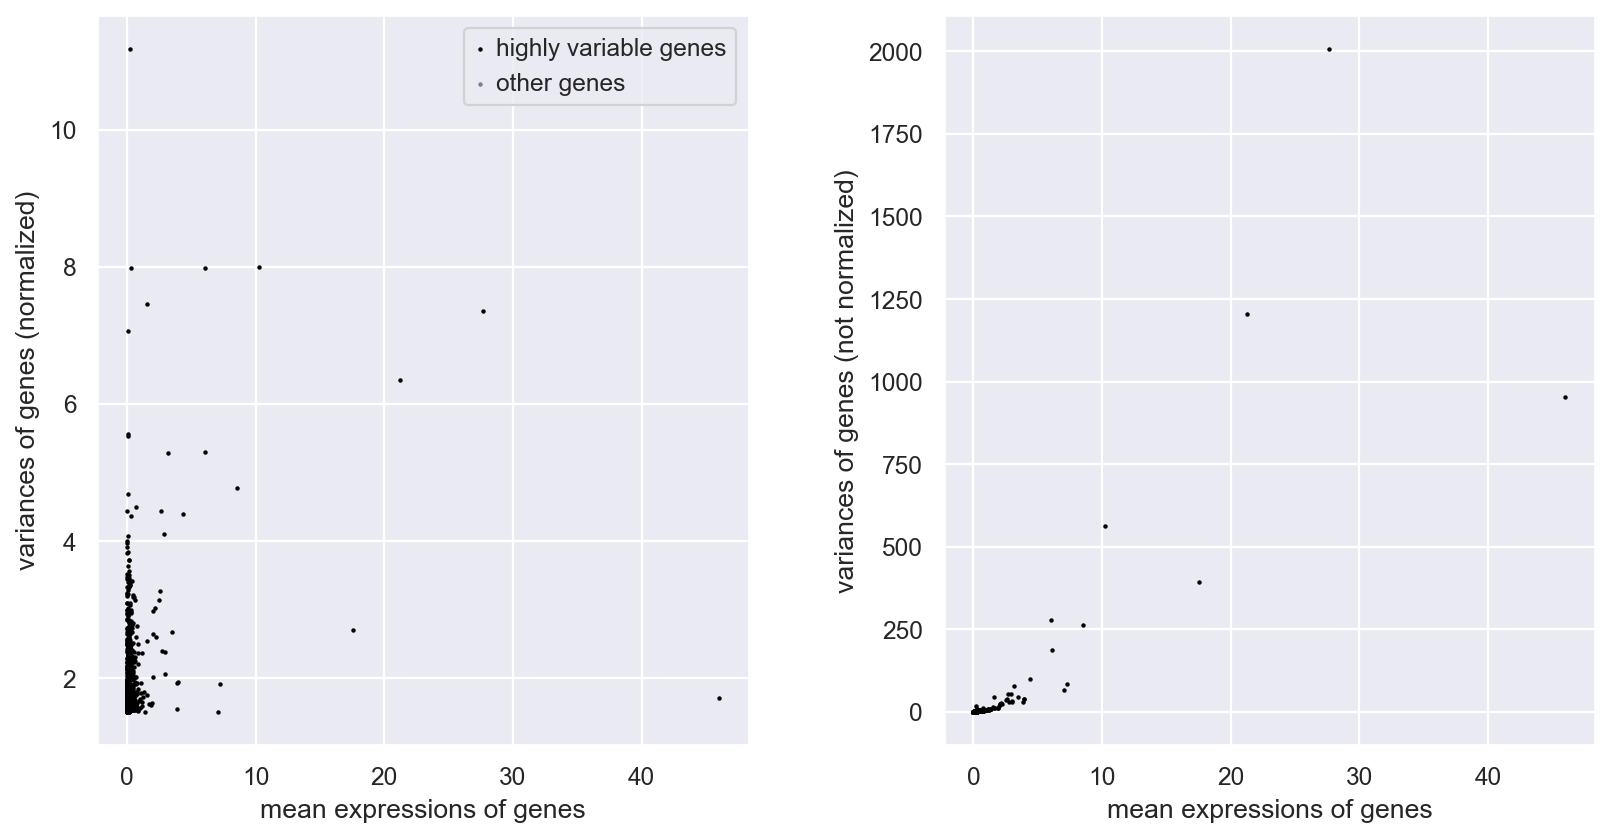

In [142]:
sc.pl.highly_variable_genes(adata)

## Running SCVI Model

In [167]:
import sys, inspect
print(inspect.getmembers(scvi))

scvi.model.SCVI.setup_anndata(adata)

model = scvi.model.SCVI(adata)

[('NullHandler', <class 'logging.NullHandler'>), ('__all__', ['set_verbosity', 'set_seed']), ('__author__', 'Romain Lopez'), ('__builtins__', {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.", '__package__': '', '__loader__': <class '_frozen_importlib.BuiltinImporter'>, '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'), '__build_class__': <built-in function __build_class__>, '__import__': <built-in function __import__>, 'abs': <built-in function abs>, 'all': <built-in function all>, 'any': <built-in function a

AttributeError: module 'scvi' has no attribute 'model'

In [166]:
print(scvi.__version__)

0.6.8
